# Conditional GAN (條件式生成對抗網路)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display
import os

## 讀入MNIST數據庫

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## 輸入格式整理&標準化
每筆輸入的資料都是28x28的陣列，但是，平常的圖都有R,G,B三個通道, 每個通道都是一個矩陣，也就是一張圖是三個矩陣!MNIST圖片是灰階，也就是只有一個通道。

### 因此，每筆資料的型式要從(28,28)改成(28,28,1)

In [3]:
BUFFER_SIZE = x_train.shape[0]
train_num = int(np.floor(x_train.shape[0]/128)*128)
BATCH_SIZE = 128
numbers_to_generate = 100
noise_dim = 100

x = ((x_train.astype("float32")-127.5)/127.5).reshape(60000,28,28,1)
y = y_train.reshape(-1, 1) # y_train.shape : (60000,) --> (60000,1) 

## 建立批次訓練資料

In [4]:
train_data_x = tf.data.Dataset.from_tensor_slices(x[:train_num]).batch(BATCH_SIZE)
train_data_y = tf.data.Dataset.from_tensor_slices(y[:train_num]).batch(BATCH_SIZE)

## 設定生成圖片的儲存路徑

In [5]:
path = 'train_figs'
if not os.path.isdir(path):
    os.mkdir(path)

# 生成器

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, ReLU, LeakyReLU, Conv2DTranspose, Flatten, concatenate, Embedding, Conv2D, Dropout
from tensorflow.keras.initializers import RandomNormal

In [7]:
def generator():
    
    # 生成器的輸入有兩部分: 用於生成圖片的噪聲以及引導其生成何種圖片的條件。
    noise = Input(shape=(noise_dim,), name = 'noise')
    label = Input(shape=(1,), name = 'label')
    
    # 將噪聲與條件調整成適當維度。這邊要注意 Embedding(10, 50)(label)，嵌入層的輸入維度要與條件的類別數相同，在此也就是0~9共十類。
    input1 = Reshape((7,7,128))(Dense(7*7*128, use_bias=False, kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(noise))
    input2 = Reshape((7,7,1))(Dense(49, use_bias=False, kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(Embedding(10, 50)(label)))
    
    # 將噪聲與條件串接起來，開始上採樣。
    h1 = ReLU()(BatchNormalization()(concatenate([input1, input2])))    
    h2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h1)
    h_2 = ReLU()(BatchNormalization()(h2))    
    h3 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h_2)
    h_3 = ReLU()(BatchNormalization()(h3))    
    h4 = Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h_3)
    h_4 = ReLU()(BatchNormalization()(h4))
    
    # 輸出時，Conv2DTranspose 的第一個參數即通道數，在此因為圖像是灰階所以設1。
    gen_pics = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='tanh', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h_4)    
    
    return Model(inputs=[noise, label], outputs=gen_pics)

In [8]:
gen = generator()

# 鑑別器

In [16]:
def discriminator():
    
    # 鑑別器的輸入有兩部分: 用於生成圖片的噪聲以及引導其生成何種圖片的條件。
    # 與生成器一樣，須調整成適當維度，以便串接。
    # Embedding 嵌入層的輸入維度也同理為10。
    pic_label = Input(shape=(1,), name='label')
    input1 = Input(shape=(28, 28, 1), name='picture')    
    input2=Reshape((28,28,1))(Dense(28*28, use_bias=False, kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(Embedding(10, 50)(pic_label)))
    
    # 下採樣的結構類似傳統CNN，不同之處在:
    #  1. 以2步伐的stride代替最大池化
    #  2. 用LeakyReLU 解決 Dead ReLU Problem(神經元壞死現象)
    conv_1 = Conv2D(32, (5,5), strides=(2,2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(concatenate([input1, input2]))
    h1 = LeakyReLU(0.2)(conv_1)
    conv_2 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h1)    
    h2 = LeakyReLU(0.2)(BatchNormalization()(conv_2))
    conv_3 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(h2)    
    h3 = LeakyReLU(0.2)(BatchNormalization()(conv_3))
    
    # 鑑別器的目的是判斷圖片的真假，因此屬於二元分類問題。
    output = Dense(1, activation='sigmoid')(Flatten()(h3))
    
    return Model(inputs=[pic, pic_label], outputs=output)

In [10]:
dis = discriminator()

DCGAN 論文 [ Radford et al. https://arxiv.org/pdf/1511.06434.pdf ] 中指出:

生成器輸出層的激發函數使用Tanh，是因為作者實驗發現使用有上下限的激發函數能更快學習，達到飽和、覆蓋訓練分布的色彩空間。

因此在鑑別器的中間層部分，激發函數使用的皆為LeakyReLU。因接收的生成器生成之資料經過Tanh映射到-1與1之間，而ReLU會將小於0的資料都映射為0，進而使得鑑別器參數難以更新。

# 損失函數

In [11]:
def G_loss(fake_pics):
    # 生成器的目的是產生圖片讓鑑別器無法分辨真假。
    # 標籤為1，即生成的圖片要讓鑑別器判斷為真。
    loss = tf.nn.sigmoid_cross_entropy_with_logits
    return loss(labels=tf.ones_like(fake_pics), logits=fake_pics)

def D_loss(real_pics, fake_pics):
    # 鑑別器的損失函數為判別真實圖像的損失與生成圖像損失的加總。
    loss = tf.nn.sigmoid_cross_entropy_with_logits
    real_pic_loss = loss(labels=tf.ones_like(real_pics), logits= real_pics)
    fake_pic_loss = loss(labels=tf.zeros_like(fake_pics), logits= fake_pics)
    total_loss = real_pic_loss + fake_pic_loss
    return total_loss

# 優化器

In [12]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
dis_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

# 訓練模型

In [13]:
def generate_and_save_image(model, test_input, epoch):
    
    label = np.array(sorted([i for i in range(10)]*10)).reshape(-1,1)
    prediction = model.predict([test_input, label]) 

    fig = plt.figure(figsize=(10,10))
    for i in range(prediction.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(prediction[i].reshape(28,28), cmap='gray', vmin=0., vmax=1.)
        plt.axis("off")
    plt.savefig(f'train_figs/train_{epoch}.png')
    plt.show()

In [14]:
@tf.function
def train_step(real_pics, real_pics_label):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_pics = gen([noise, real_pics_label], training=True)
        fake_pics = dis([generated_pics, real_pics_label], training=True)
        real_pics = dis([real_pics, real_pics_label], training=True)

        generator_loss = G_loss(fake_pics)
        discriminator_loss = D_loss(real_pics, fake_pics)

    # 計算各變數的梯度
    gen_gradients = gen_tape.gradient(generator_loss, gen.trainable_variables)
    dis_gradients = dis_tape.gradient(discriminator_loss, dis.trainable_variables)
    # 更新各變數
    gen_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_variables))
    dis_optimizer.apply_gradients(zip(dis_gradients, dis.trainable_variables))

In [15]:
def train(train_data_x, train_data_y, epochs):
    
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        # 產生噪聲
        seed = tf.random.normal([numbers_to_generate, noise_dim])
        for img_batch, label_batch in zip(train_data_x, train_data_y):
            train_step(img_batch, label_batch)

        display.clear_output(wait=True)
        generate_and_save_image(gen, seed, epoch)
    # 訓練結束後再生成一次圖片    
    display.clear_output(wait=True)   
    generate_and_save_image(gen, seed, epoch)

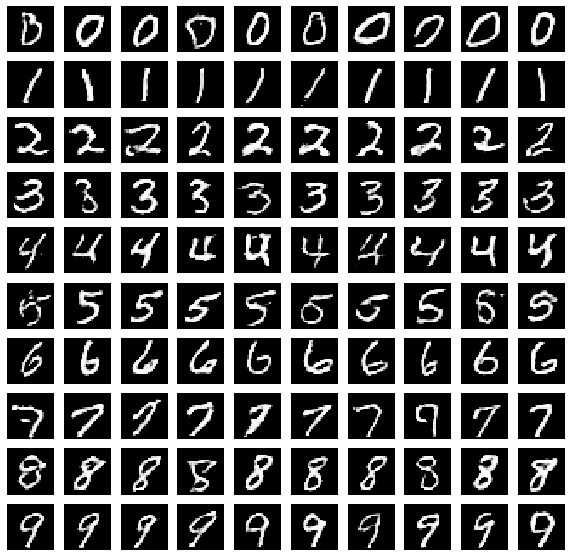

In [19]:
train(train_data_x, train_data_y, 10)

# 圖像生成訓練過程

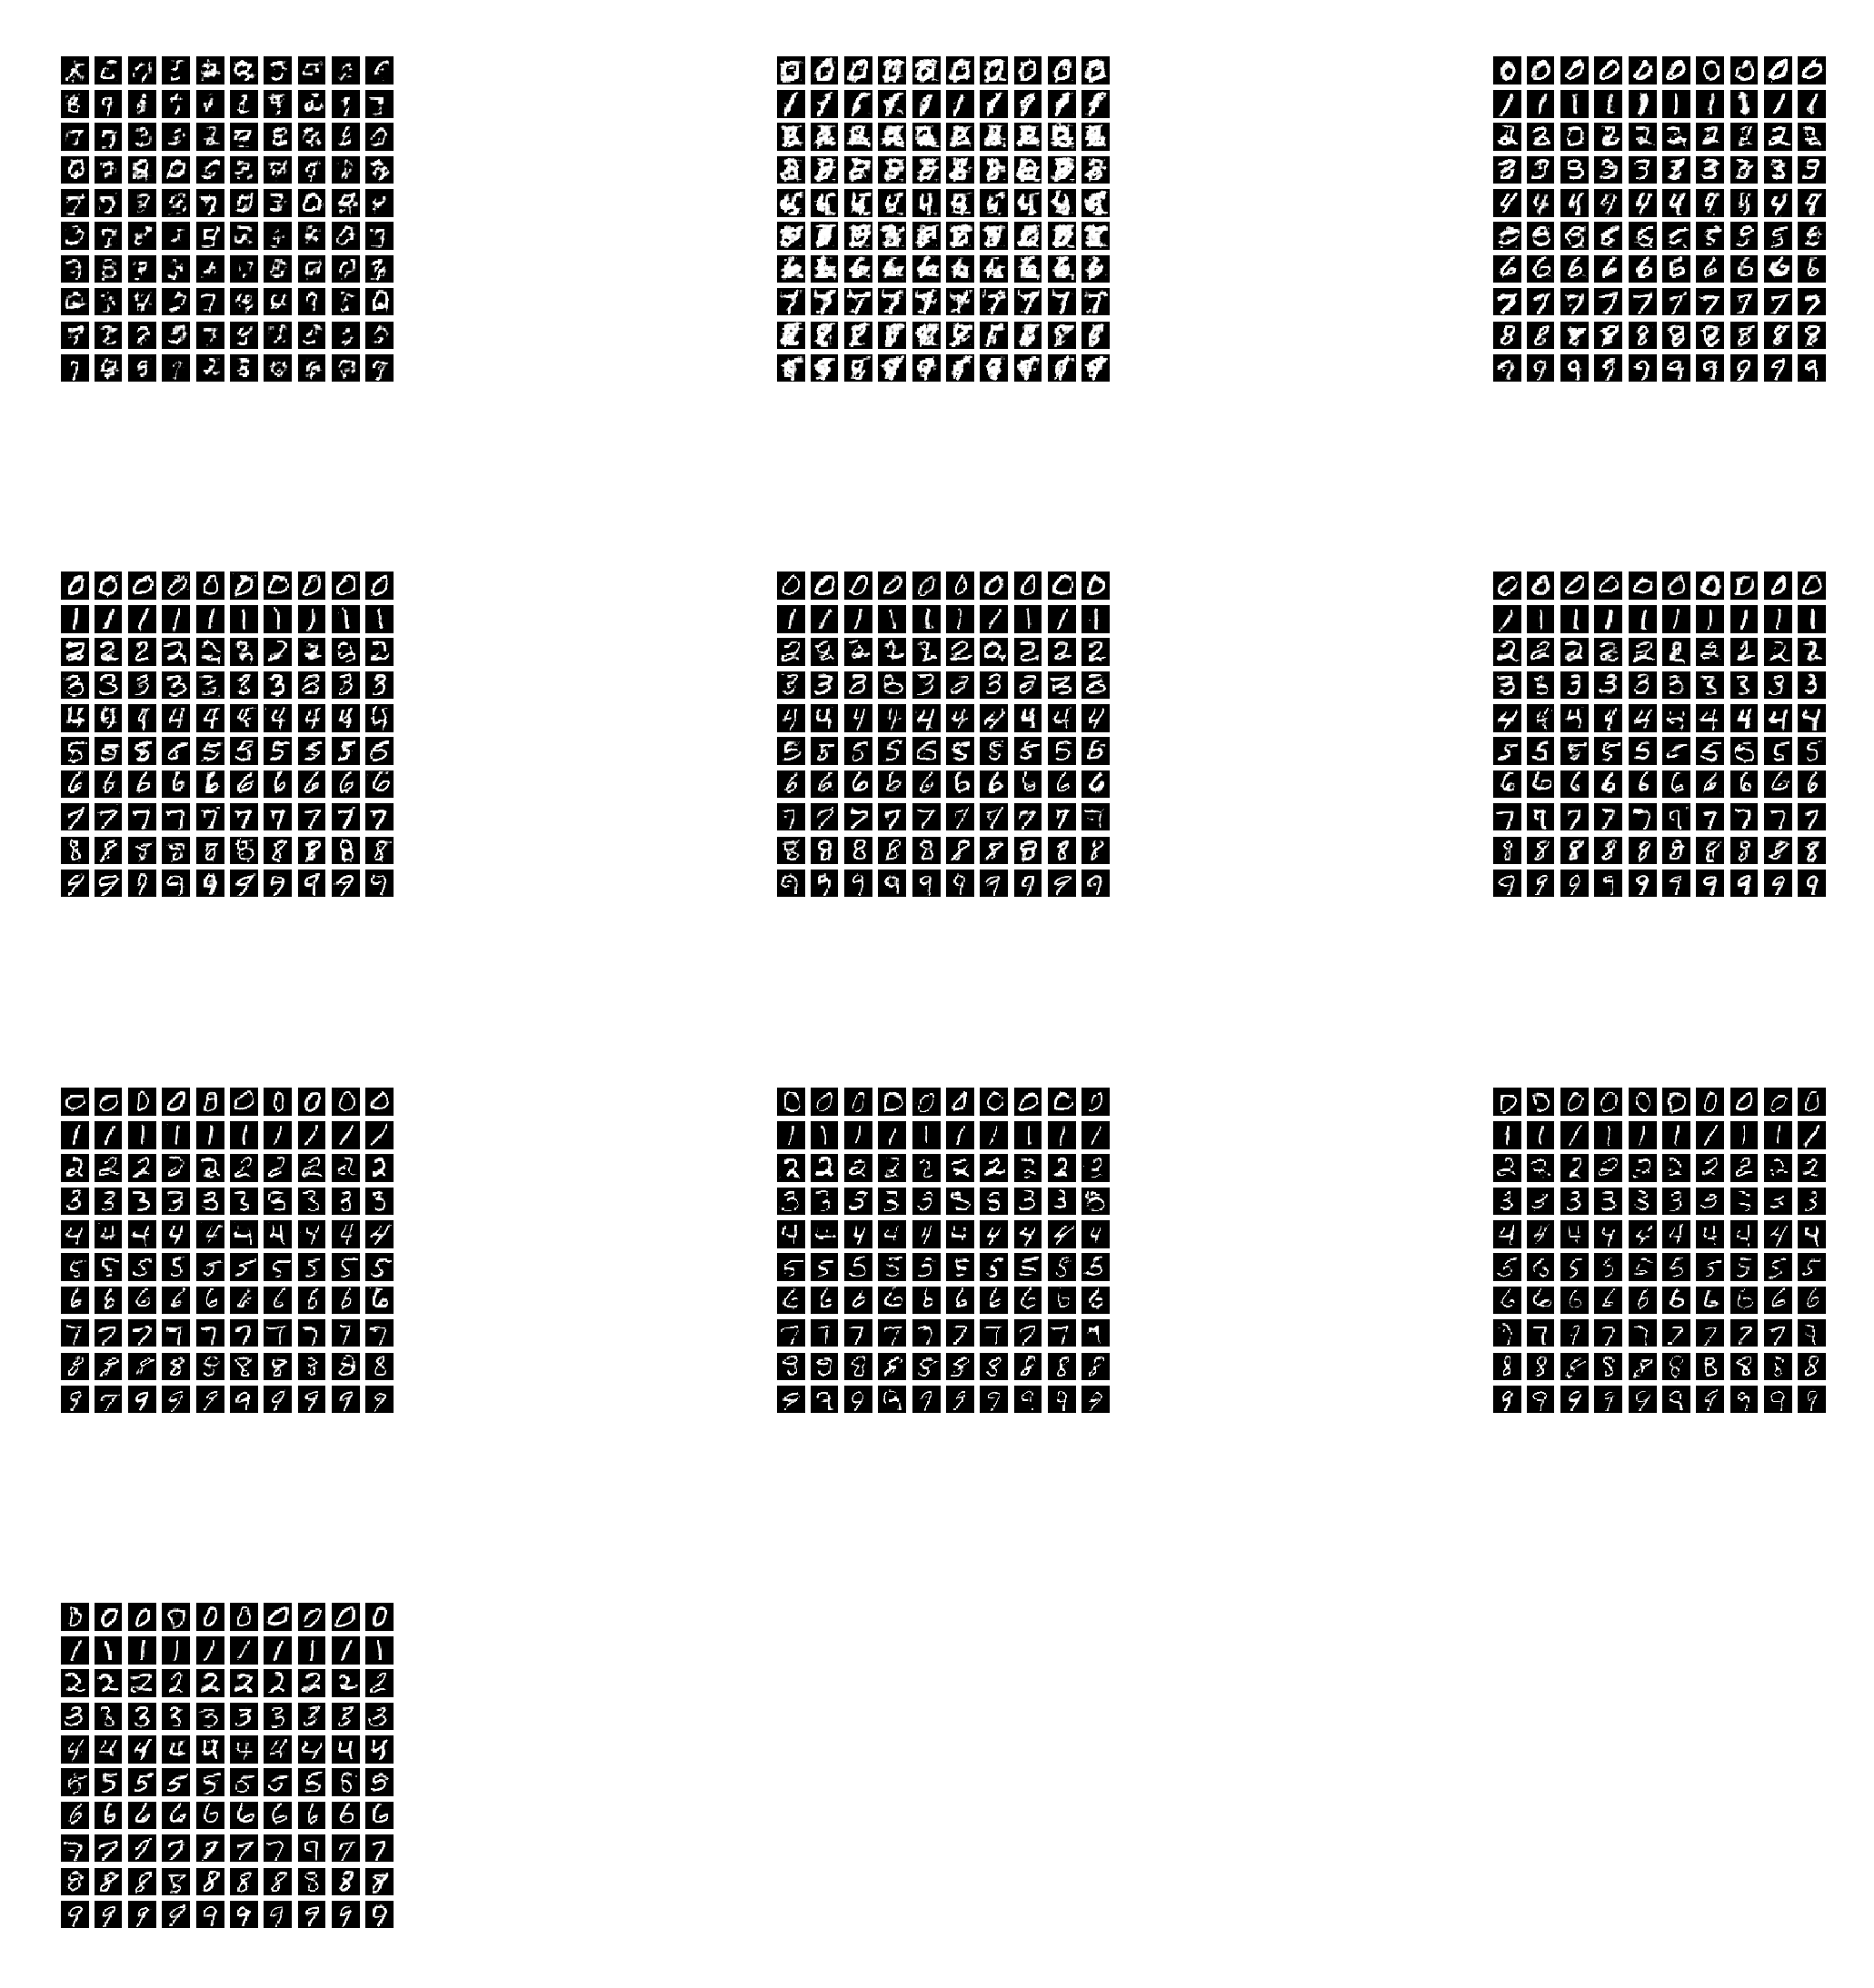

In [18]:
imgs = []
for i in range(10):
    imgs.append(plt.imread(f'./GAN_figs/CGAN_mnist/train_{i}.png'))
    
fig = plt.figure(figsize=(40,40))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.imshow(imgs[i], cmap='gray', vmin=0., vmax=1.)
    plt.axis("off")
plt.show()

# 生成器(左)與鑑別器(右)的架構

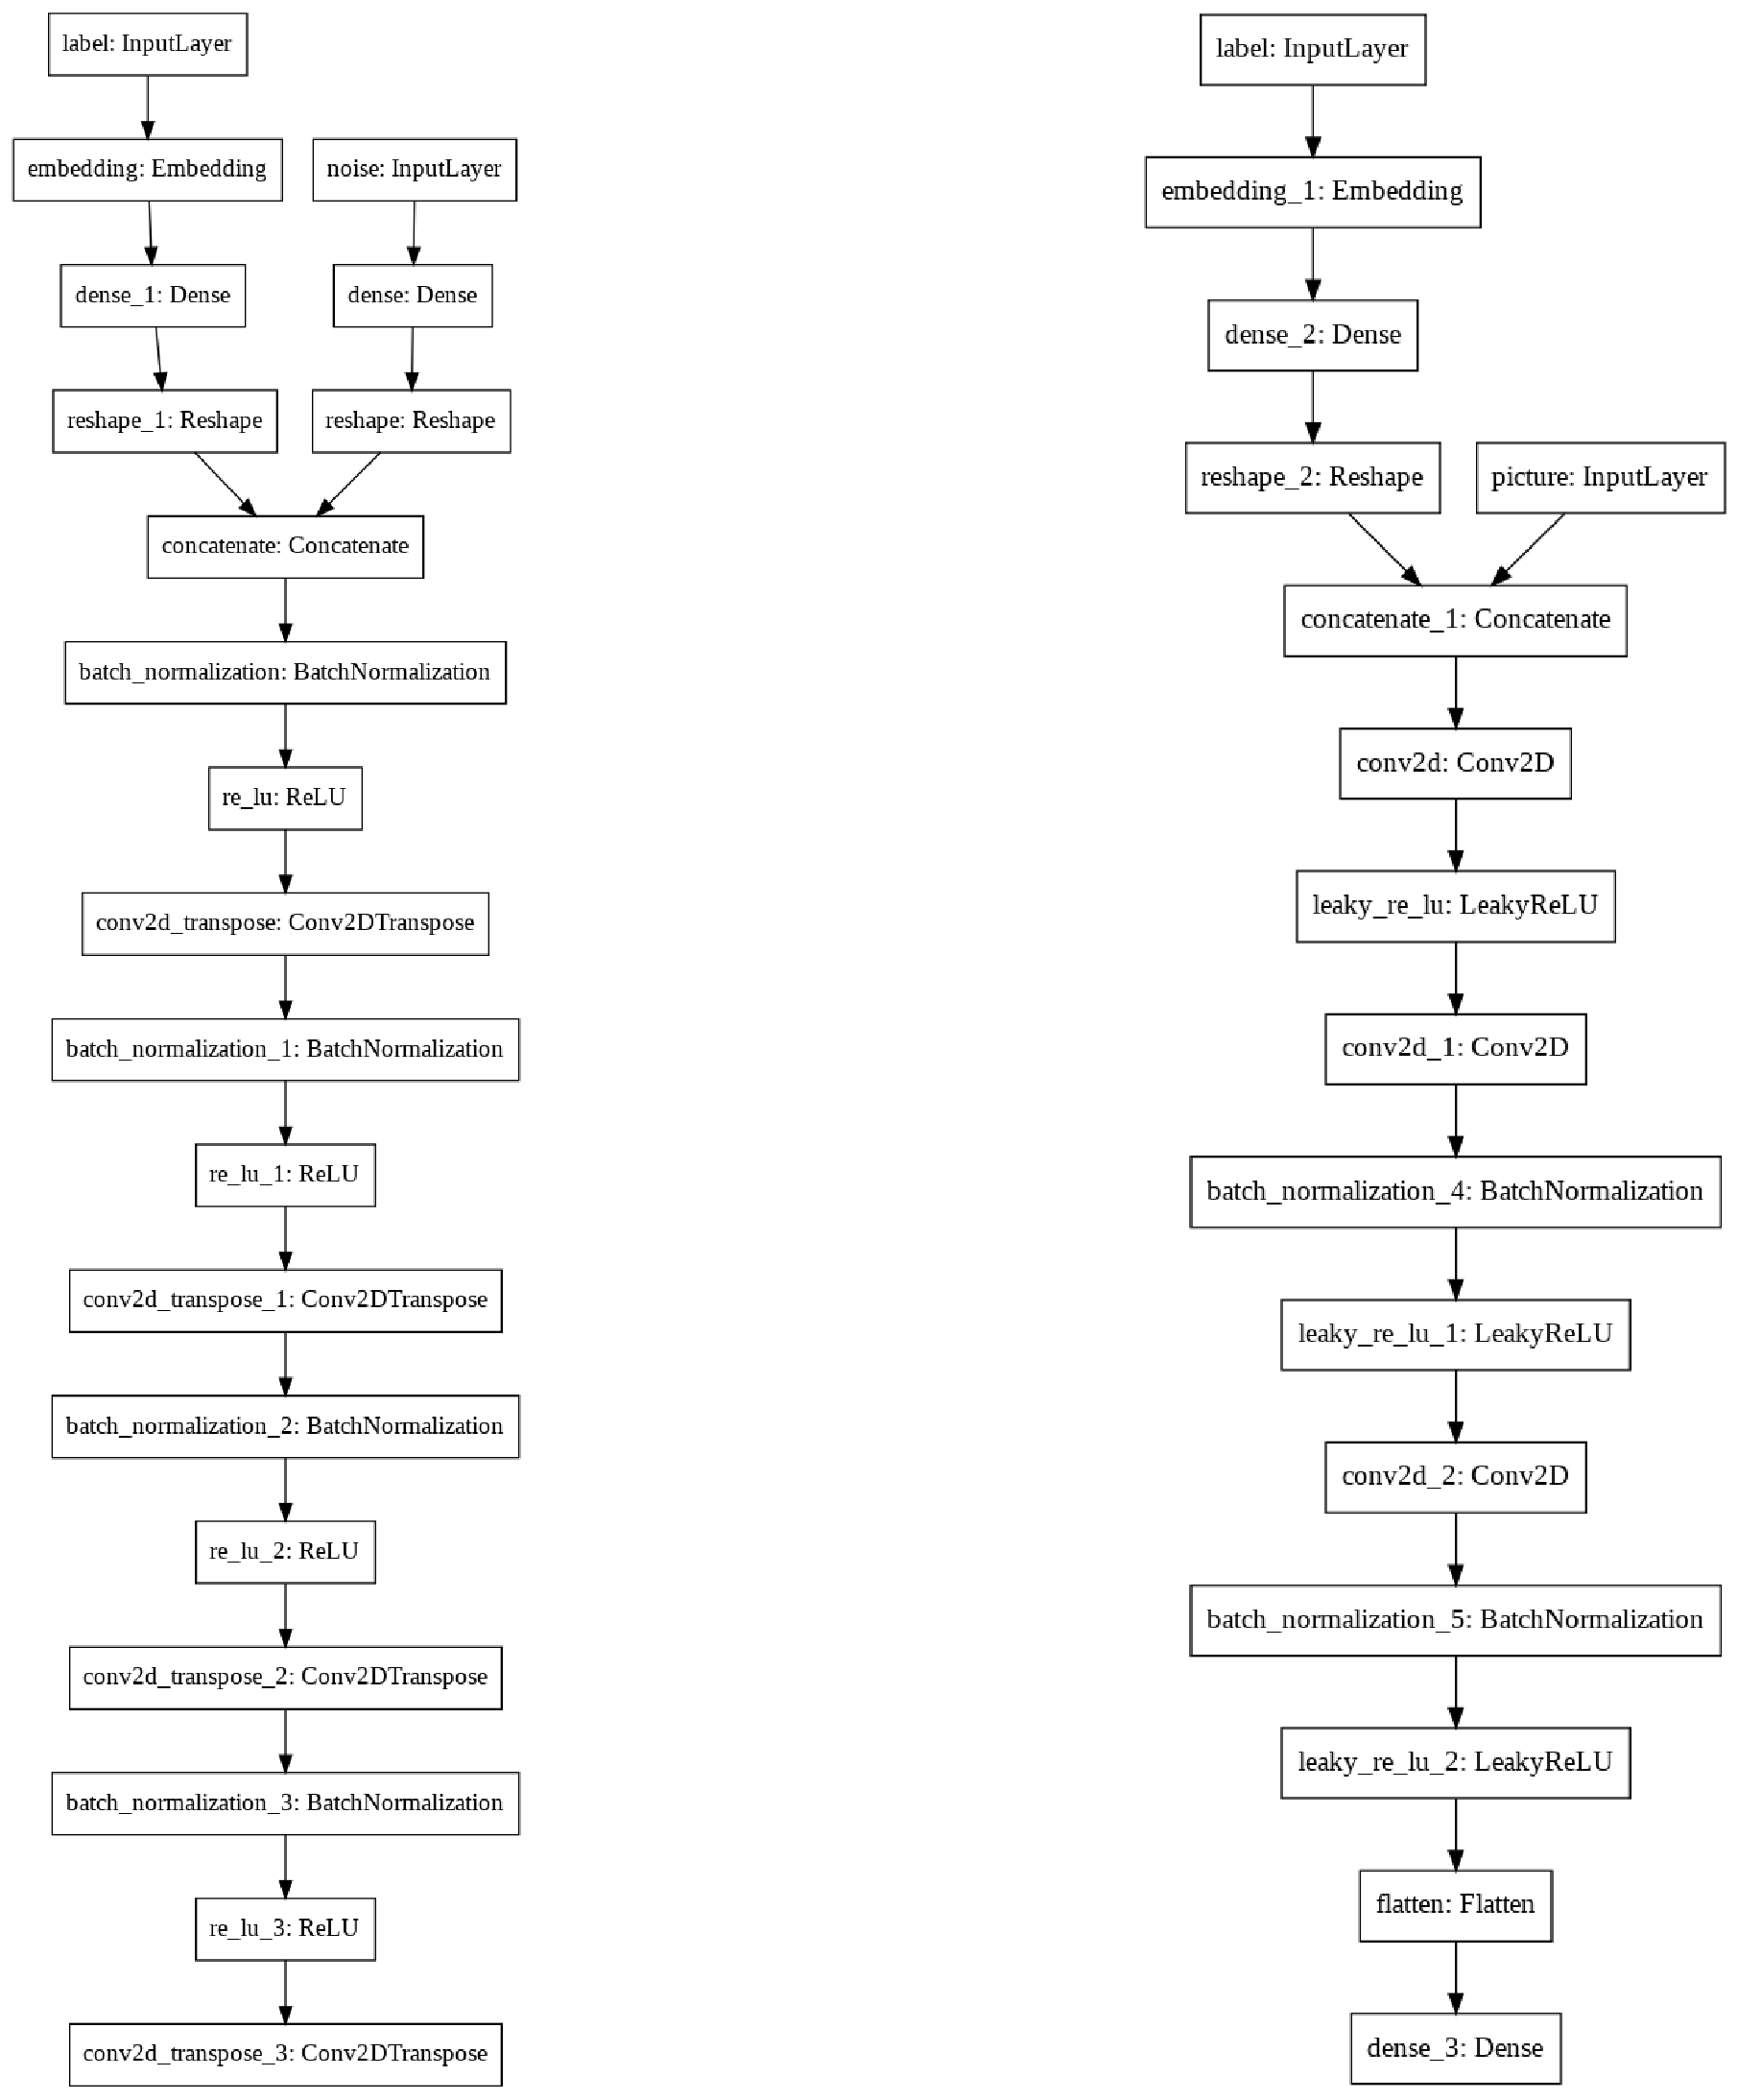

In [19]:
imgs = []
imgs.append(plt.imread(f'./gen.png'))
imgs.append(plt.imread(f'./dis.png'))
fig = plt.figure(figsize=(40,40))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(imgs[i], cmap='gray', vmin=0., vmax=1.)
    plt.axis("off")
plt.show()

(-0.5, 605.5, 554.5, -0.5)

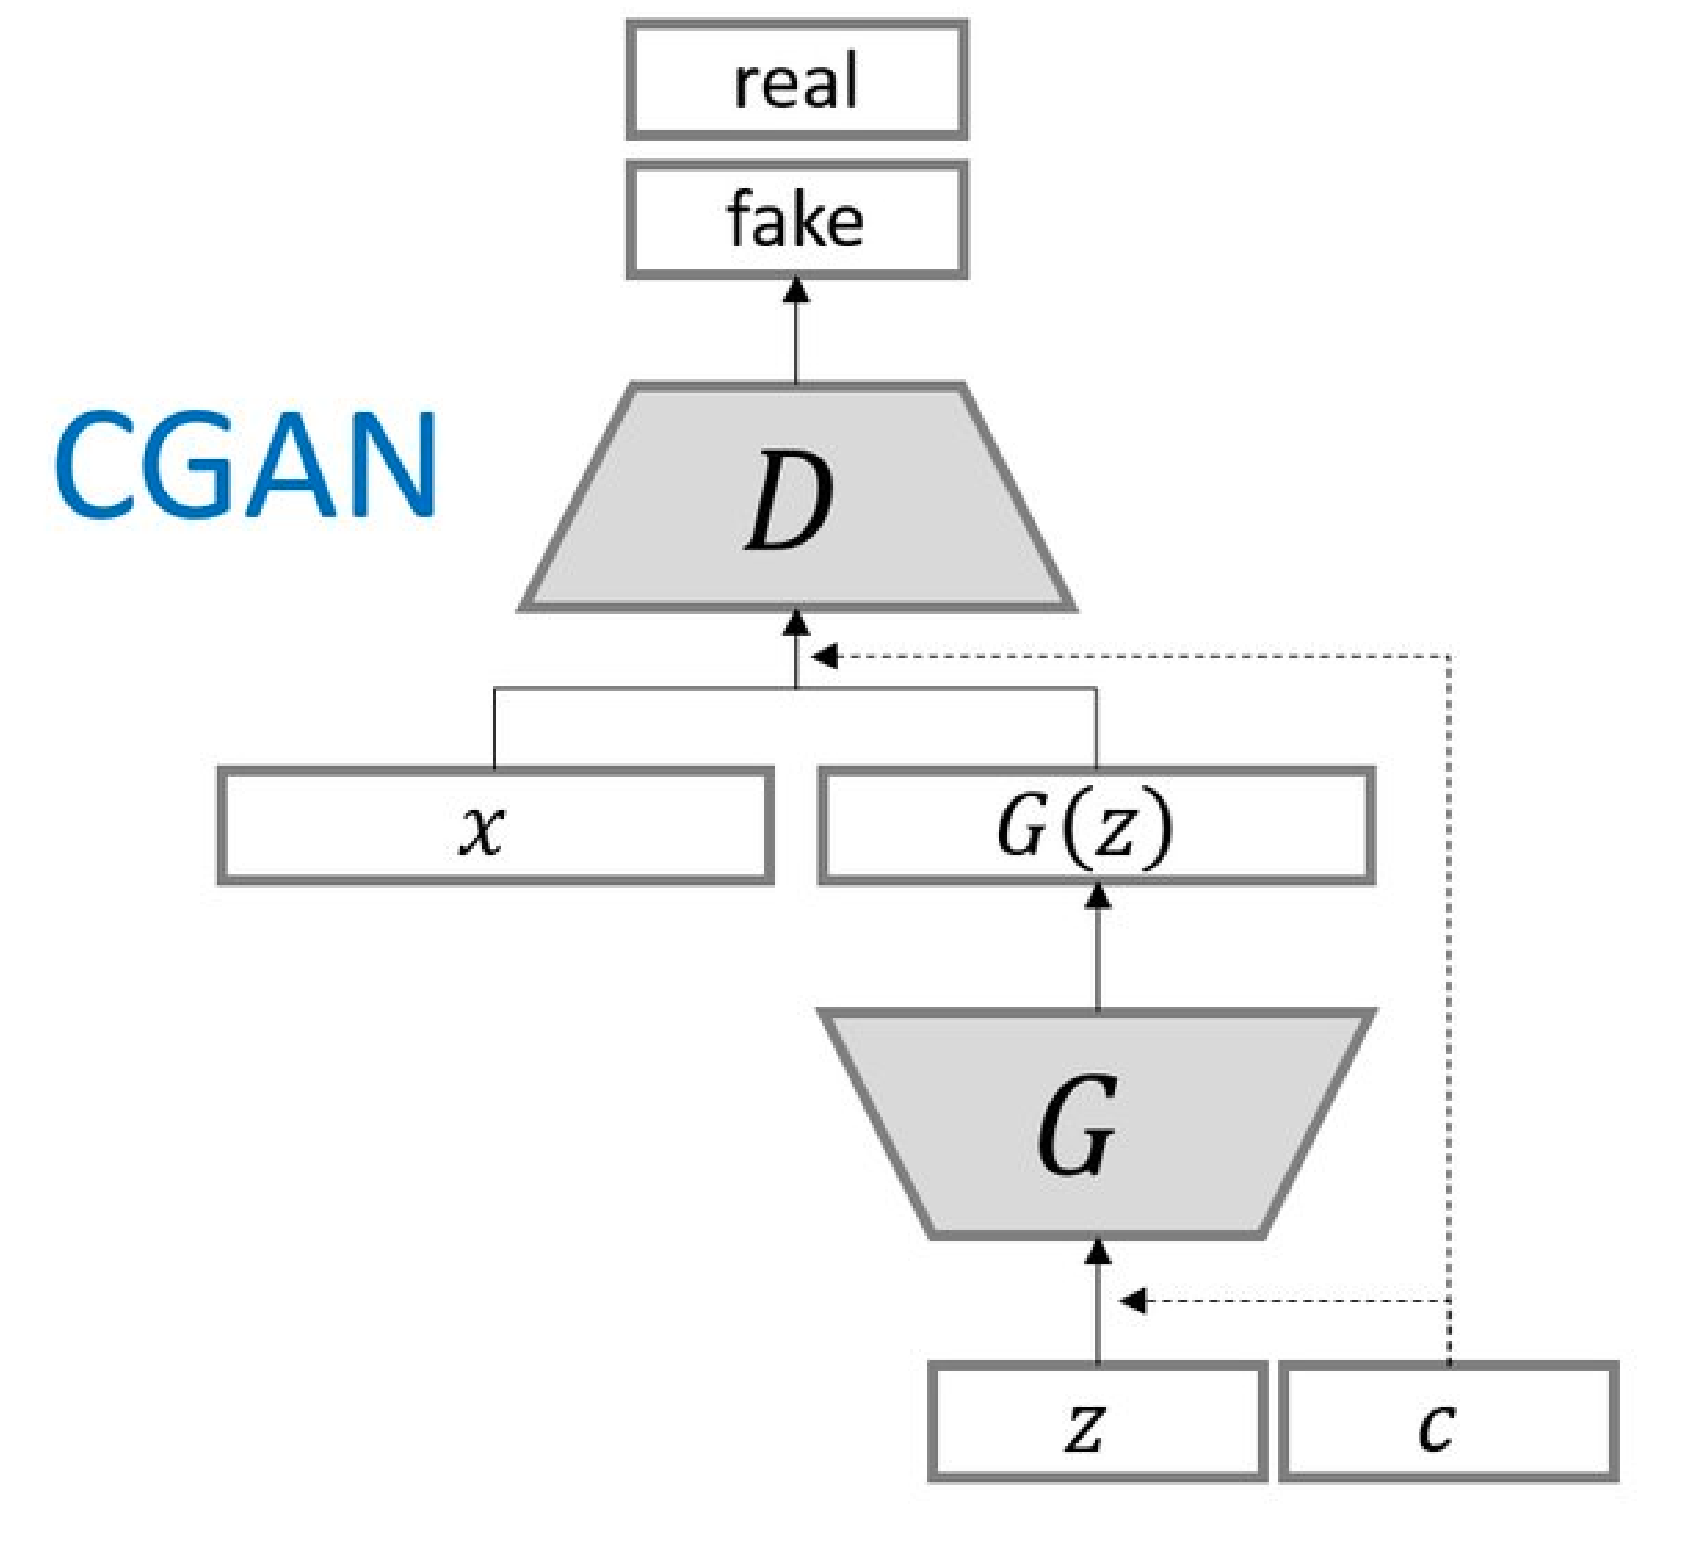

In [20]:
plt.figure(figsize=(30,30))
architecture = plt.imread('cgan.png')
plt.imshow(architecture)
plt.axis("off")

### 上圖為條件式生成對抗網路的整體架構，由生成器與鑑別器相互對抗、不斷調整參數，最終目的是使鑑別器無法判斷生成器的輸出結果是否真實。

## 參考資料:

1. https://khhuang.net/blog/machine%20leaning/2017/06/19/gan-and-conditional-gan.html
2. M. Mirza and S. Osindero. “Conditional generative adversarial nets.” Preprint arXiv:1411.1784, 2014.
3. 台大李宏毅老師的GAN Lecture 2 (2018): Conditional Generation https://www.youtube.com/watch?v=LpyL4nZSuqU&index=2&list=PLJV_el3uVTsMq6JEFPW35BCiOQTsoqwNw